# TCN Classification
<hr>




## Load the library

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import os
import random
import json
# from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import KFold

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

In [13]:
tf.config.list_physical_devices('GPU') 

[]

## Load the Dataset

In [3]:
# JSON formatting functions
def convert_data_to_spacy(JSON_FilePath):
    training_data = []
    lines=[]
    with open(JSON_FilePath, 'r') as f:
        lines = f.readlines()

    for line in lines:
        data = json.loads(line)
        text = data['data']
        data_annotations = data['label']
        training_data.append((text, {"entities" : data_annotations}))
    return training_data


def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data

In [4]:
datas = trim_entity_spans(convert_data_to_spacy("D://pythonProject/Internship/Resume Screening/data/annotated_json_data/admin.jsonl"))
datas[0]

['le dinh thinh java developer date birth december 5th 2002 phone 0335 290 096 gender male email ldt051202@gmail.com address 49/97 nguyen luong bang lien chieu da nang city website https://www.facebook.com/thinhle0512 objective wishing professional stable developed working environment long-term attachment company develop professional skills learn new programming knowledge get things done next 2 years become professional backend programmer java programming language learn programming languages education sep 2020 april 2021 codegym da nang work experience february 2021 march 2021 insurance sales website developer team size 16 persons skills java core spring boot mysql html 5 angular spring mvc interests discover backend spring framework spring data spring web services spring boot mysql workbench 8.0 ce firebase toupload image file frontend angular 9 html 5 bootstrap 4 css 3 project managerment registry selling refund customer car want buy car insurance tasks list create product informatio

In [5]:
def clean_entities(training_data):
    
    clean_data = []
    for text, annotation in training_data:
        
        entities = annotation.get('entities')
        entities_copy = entities.copy()
        
        # append entity only if it is longer than its overlapping entity
        i = 0
        for entity in entities_copy:
            j = 0
            for overlapping_entity in entities_copy:
                # Skip self
                if i != j:
                    e_start, e_end, oe_start, oe_end = entity[0], entity[1], \
                    overlapping_entity[0], overlapping_entity[1]
                    # Delete any entity that overlaps, keep if longer
                    if ((e_start >= oe_start and e_start <= oe_end) \
                    or (e_end <= oe_end and e_end >= oe_start)) \
                    and ((e_end - e_start) <= (oe_end - oe_start)):
                        entities.remove(entity)
                j += 1
            i += 1
        clean_data.append((text, {'entities': entities}))
                
    return clean_data

datas = clean_entities(datas)

In [6]:
datas

[('le dinh thinh java developer date birth december 5th 2002 phone 0335 290 096 gender male email ldt051202@gmail.com address 49/97 nguyen luong bang lien chieu da nang city website https://www.facebook.com/thinhle0512 objective wishing professional stable developed working environment long-term attachment company develop professional skills learn new programming knowledge get things done next 2 years become professional backend programmer java programming language learn programming languages education sep 2020 april 2021 codegym da nang work experience february 2021 march 2021 insurance sales website developer team size 16 persons skills java core spring boot mysql html 5 angular spring mvc interests discover backend spring framework spring data spring web services spring boot mysql workbench 8.0 ce firebase toupload image file frontend angular 9 html 5 bootstrap 4 css 3 project managerment registry selling refund customer car want buy car insurance tasks list create product informati

In [7]:
from nltk.tokenize import WhitespaceTokenizer

df_data = pd.DataFrame(columns=["token", "label"])

for data in datas:
    entities = data[1]["entities"]
    words = []
    labels = []
    
    token = data[0].split()
    span_generator = WhitespaceTokenizer().span_tokenize(data[0])
    spans = [span for span in span_generator]
    
    for word, span in zip(token, spans):
        words.append(word)
        found = False
        for entity in sorted(entities):
            ent_start = entity[0]
            ent_end = entity[1]
            if ent_start <= span[0] <= ent_end:
                labels.append(1)
                found = True
                break
        if not found:
            labels.append(0)

    for i in range(len(labels)):
        df_data = df_data.append({'token': words[i], 'label': labels[i]}, ignore_index=True)

df_data

,token,label
0,le,0
1,dinh,0
2,thinh,0
3,java,0
4,developer,0
...,...,...
277325,trips,0
277326,video,0
277327,games,0
277328,new,0


In [14]:
df_label_pos = df_data[df_data['label'] == 1]
df_label_pos

,token,label
86,java,1
87,core,1
88,spring,1
89,boot,1
90,mysql,1
...,...,...
277291,mongodb,1
277303,rest,1
277304,api,1
277305,docker,1


In [12]:
df_data['label'] = df_data['label'].astype(str).astype(int)

In [13]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277330 entries, 0 to 277329
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   277330 non-null  object
 1   label   277330 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 3.2+ MB


In [23]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_data, test_size=0.05)

In [24]:
train.shape, test.shape

((263463, 2), (13867, 2))

In [25]:
# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_x = list(train[:]['token'])
train_y = np.array(train[:]['label'], dtype=np.float)
print(len(train_x))
print(len(train_y))

test_x = list(test[:]['token'])
test_y = np.array(test[:]['label'], dtype=np.float)
print(len(test_x))
print(len(test_y))

263463
263463
13867
13867


In [26]:
train_x[100], train_y[100]

('1', 0.0)

<!--## Split Dataset-->

# Data Preprocessing

- <b>One way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set.</b>

In [27]:
# Define a function to compute the max length of sequence
def max_length(sequences):
    '''
    input:
        sequences: a 2D list of integer sequences
    output:
        max_length: the max length of the sequences
    '''
    max_length = 0
    for i, seq in enumerate(sequences):
        length = len(seq)
        if max_length < length:
            max_length = length
    return max_length

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train_x)

print("Example of sentence: ", train_x[4])

# Turn the text into sequence
training_sequences = tokenizer.texts_to_sequences(train_x)
testing_sequences = tokenizer.texts_to_sequences(test_x)
max_len = max_length(training_sequences)

print('Into a sequence of int:', training_sequences[4])

# Pad the sequence to have the same size
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

print('Into a padded sequence:', training_padded[4])

Example of sentence:  school
Into a sequence of int: [187]
Into a padded sequence: [187   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [29]:
max_len

14

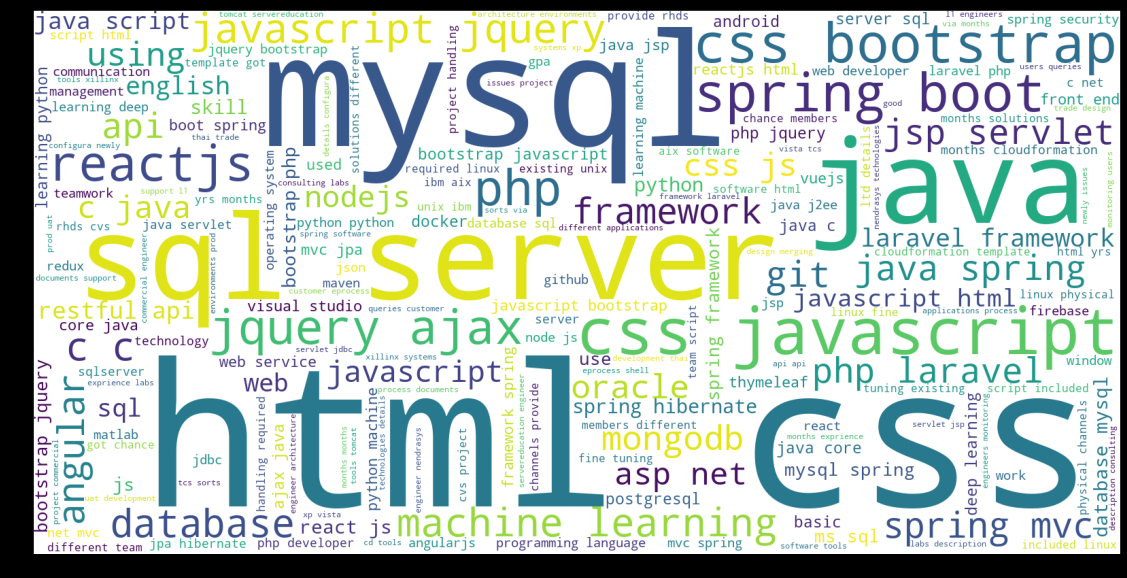

In [35]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(df_label_pos['token'].tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

In [70]:
# See the first 10 words in the vocabulary
word_index = tokenizer.word_index
vocab_size = len(word_index)+1
print(vocab_size)

11675


## Save vocab

In [79]:
file = open("D://pythonProject/Internship/Resume Screening/Entity Extraction/Classification/data/vocab.txt", "w+")
file.write(json.dumps(word_index))
file.close()

## Saving tokenizer

In [73]:
import pickle

# saving
with open('D://pythonProject/Internship/Resume Screening/Entity Extraction/Classification/data/tokenizer.pickle', 'wb+') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# loading
with open('D://pythonProject/Internship/Resume Screening/Entity Extraction/Classification/data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## TCN Model

Now, we will build Temporal Convolutional Network (CNN) models to classify encoded documents as either positive or negative.

The model takes inspiration from https://github.com/philipperemy/keras-tcn and https://www.kaggle.com/christofhenkel/temporal-convolutional-network

__Arguments__
`TCN(nb_filters=64, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32], padding='causal', use_skip_connections=False, dropout_rate=0.0, return_sequences=True, activation='relu', kernel_initializer='he_normal', use_batch_norm=False, **kwargs)`

- `nb_filters`: Integer. The number of filters to use in the convolutional layers. Would be similar to units for LSTM.
- `kernel_size`: Integer. The size of the kernel to use in each convolutional layer.
- `dilations`: List. A dilation list. Example is: [1, 2, 4, 8, 16, 32, 64].
- `nb_stacks`: Integer. The number of stacks of residual blocks to use.
- `padding`: String. The padding to use in the convolutions. 'causal' for a causal network (as in the original implementation) and - `'same' for a non-causal network.
- `use_skip_connections`: Boolean. If we want to add skip connections from input to each residual block.
- `return_sequences`: Boolean. Whether to return the last output in the output sequence, or the full sequence.
- `dropout_rate`: Float between 0 and 1. Fraction of the input units to drop.
- `activation`: The activation used in the residual blocks o = activation(x + F(x)).
- `kernel_initializer`: Initializer for the kernel weights matrix (Conv1D).
- `use_batch_norm`: Whether to use batch normalization in the residual layers or not.
- `kwargs`: Any other arguments for configuring parent class Layer. For example "name=str", Name of the model. Use unique names when using multiple TCN.

Now, we will define our TCN model as follows:
- One TCN layer with 100 filters, kernel size 5, and relu activation function;
- Dropout size = 0.5;
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

**Note**: 
- The whole purpose of dropout layers is to tackle the problem of over-fitting and to introduce generalization to the model. Hence it is advisable to keep dropout parameter near 0.5 in hidden layers. 
- https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/

In [80]:
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

def define_model(kernel_size = 3, activation='relu', input_dim = None, output_dim=300, max_length = None ):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = TCN(128, dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64, dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(2, activation="softmax")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [81]:
model_0 = define_model(input_dim=1000, max_length=100)
model_0.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     300000      input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
tcn1 (TCN)                      (None, 100, 128)     400256      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [82]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=20, verbose=2, 
                                             mode='auto', restore_best_weights=True)

## Train and Test the Model

In [83]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [84]:
# Parameter Initialization
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"
activations = 'relu'
filters = 100
kernel_sizes = 5

columns = ['Activation', 'Filters', 'Acc']
record = pd.DataFrame(columns = columns)

acc_max = 0

print('-------------------------------------------')
print('Training {}: {} activation, {} kernel size.'.format(exp, activation, kernel_size))
print('-------------------------------------------')

# Define the input shape
model = define_model(kernel_size, activation, input_dim=vocab_size, max_length=max_len)

# Train the model and initialize test accuracy with 0
acc = 0
while(acc<0.7):
    history = model.fit(training_padded, train_y, batch_size=50, epochs=10, verbose=1, 
              callbacks=[callbacks], validation_data=(testing_padded, test_y))

    # evaluate the model
    loss, acc = model.evaluate(testing_padded, test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))

    if (acc<0.6):
        print('The model suffered from local minimum. Retrain the model!')
        model = define_model(kernel_size, activation, input_dim=vocab_size, max_length=max_len)

    else:

        if acc > acc_max:
            acc_max = acc
            model.save('D://pythonProject/Internship/Resume Screening/Entity Extraction/Classification/model/model_best.h5')
        print('Done!')

parameters = [activation, kernel_size]
entries = parameters + [acc]

temp = pd.DataFrame([entries], columns=columns)
record = record.append(temp, ignore_index=True)
print()
print(record)
print()

print('model co do chinh xac cao nhat:', acc_max)

-------------------------------------------
Training 1: relu activation, 5 kernel size.
-------------------------------------------
Epoch 1/10
5270/5270 [==============================] - 293s 55ms/step - loss: 0.1647 - accuracy: 0.9469 - val_loss: 0.1571 - val_accuracy: 0.9489
Epoch 2/10
5270/5270 [==============================] - 301s 57ms/step - loss: 0.1454 - accuracy: 0.9506 - val_loss: 0.1588 - val_accuracy: 0.9491
Epoch 3/10
5270/5270 [==============================] - 289s 55ms/step - loss: 0.1425 - accuracy: 0.9509 - val_loss: 0.1569 - val_accuracy: 0.9493
Epoch 4/10
5270/5270 [==============================] - 321s 61ms/step - loss: 0.1412 - accuracy: 0.9509 - val_loss: 0.1600 - val_accuracy: 0.9490
Epoch 5/10
5270/5270 [==============================] - 313s 59ms/step - loss: 0.1404 - accuracy: 0.9510 - val_loss: 0.1586 - val_accuracy: 0.9492
Epoch 6/10
5270/5270 [==============================] - 327s 62ms/step - loss: 0.1399 - accuracy: 0.9511 - val_loss: 0.1630 - val_acc

## Summary

In [85]:
record.sort_values(by='Acc', ascending=False)

,Activation,Filters,Acc
0,relu,5,0.949088


In [ ]:
# report = record.sort_values(by='Acc', ascending=False)
# report = report.to_excel('TCN_TREC.xlsx', sheet_name='random')

## Test model 

In [63]:
from tensorflow import keras
from tcn import TCN, tcn_full_summary
model = keras.models.load_model('D://pythonProject/Internship/Resume Screening/Entity Extraction/Classification/model/model_best.h5'
                               ,{"TCN":TCN})

In [64]:
CV_test_path = 'D://pythonProject/Internship/Resume Screening/data/preprocessed_txt_data/JAVA/[TonThatToan]CV-Java_Developer_En_v2021 (1).txt'
file_cv = open(str(CV_test_path), 'r')
test_data_cv = file_cv.read()
test_data_cv = test_data_cv.split()

test_sequences = tokenizer.texts_to_sequences(test_data_cv)

max_len = max_length(training_sequences)

CVtest = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

predict = model.predict(CVtest, verbose=0)
yhat_probs = np.argmax(predict, axis=1)

In [70]:
print(' '.join(test_data_cv))

ton toan java developer da nang viet nam date birth 01/03 1991 phone 0363 087 497 email toantp.91@gmail.com career objective developer strive challenging interesting working environment especially development applications aim affirm contribute knowledge skills experience promote career software developer job objectives next years skills development languages java javascript sql c # jsp html css frameworks spring core security data boot hibernate liferay database oracle sql server mysql postgresql deployment apache tomcat docker nginx software visual studio code eclipse netbeans languages vietnamese native english basic education 2014 graduated university information technology duy tan university 2010 work experience green global co ltd da nang java developer 07/2015 -- present worked position java developer projects developing product solutions government contributes viet nam e-government use java j2ee technologies develop web applications client server environments add functionalities

In [77]:
#test
count = 0
for i in range(len(test_data_cv)):  
    if (yhat_probs[i]==0):
        print(test_data_cv[i],' ---------> Unknow')     
    elif (yhat_probs[i]==1):
        count += 1
        print(test_data_cv[i],' ---------> Knowleadge') 
print('Dem duoc: ',count ,' tu thuoc Knowleaged')

ton  ---------> Unknow
toan  ---------> Unknow
java  ---------> Unknow
developer  ---------> Unknow
da  ---------> Unknow
nang  ---------> Unknow
viet  ---------> Knowleadge
nam  ---------> Unknow
date  ---------> Unknow
birth  ---------> Unknow
01/03  ---------> Unknow
1991  ---------> Unknow
phone  ---------> Unknow
0363  ---------> Unknow
087  ---------> Unknow
497  ---------> Unknow
email  ---------> Unknow
toantp.91@gmail.com  ---------> Unknow
career  ---------> Unknow
objective  ---------> Unknow
developer  ---------> Unknow
strive  ---------> Unknow
challenging  ---------> Unknow
interesting  ---------> Unknow
working  ---------> Unknow
environment  ---------> Unknow
especially  ---------> Unknow
development  ---------> Unknow
applications  ---------> Unknow
aim  ---------> Unknow
affirm  ---------> Unknow
contribute  ---------> Unknow
knowledge  ---------> Unknow
skills  ---------> Unknow
experience  ---------> Unknow
promote  ---------> Unknow
career  ---------> Unknow
softwa

In [72]:
knowledge = ''
for i in range(len(test_data_cv)):
  if (yhat_probs[i]==1):
    knowledge += ' ' + test_data_cv[i]
print(knowledge)

 viet objectives javascript html spring viet spring spring spring 2 2 committee spring function spring beauty beauty hair women women hair rivers javascript spring committee detecting spring committee javascript spring


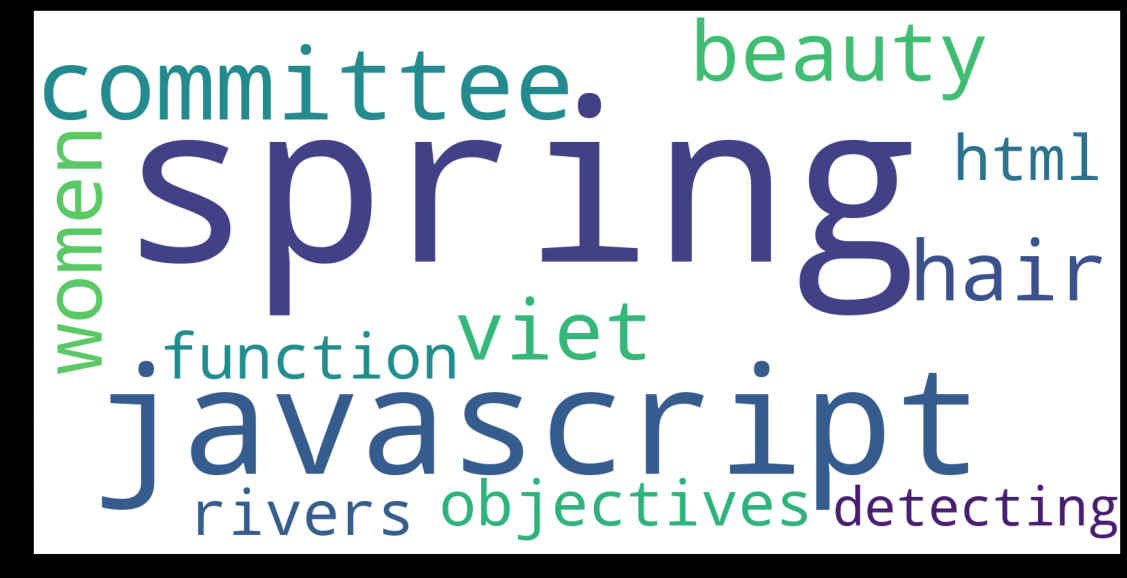

In [73]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(knowledge)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

## CV

In [98]:
projectDir = 'D://pythonProject/Internship/Resume Screening/data/'
cleanResumeDir = projectDir+'preprocessed_txt_data/'

arr_dir = ['3D', 'Admin - CTV', 'AI', 'BLOCKCHAIN', 'C#', 'DEVOPS', 'HELPDESK', 'JAVA', 'KAGGLE', 'PHP', 'PYTHON', 'REACTJS',
          'RUBY', 'TESTER', 'UNITY', 'INTERN/OK', 'INTERN/PNV', 'INTERN/SUMMER INTERN 2021',
           'INTERN/SUMMER INTERN 2021/Intern Blockchain', 'NODEJS/I.2021', 'NODEJS/II.2021']
all_doc = []
all_doc_name = []

In [99]:
for dir in arr_dir:
    new_dir = cleanResumeDir+dir
    os.chdir(new_dir)
    for clean_resume in os.listdir(new_dir):
        if clean_resume == "Intern Blockchain":
            continue
        file = open(str(clean_resume), 'r')
        resume = file.read()
        all_doc.append(resume)
        all_doc_name.append(dir+'/'+clean_resume)
len(all_doc)

505

In [100]:
cv = []
for i in range(len(all_doc)):
    cv.append(all_doc[i].split())
print(len(cv))

505


In [101]:
sequences_cv = []
for i in range(len(cv)):
    sequences_cv.append(tokenizer.texts_to_sequences(cv[i]))
len(sequences_cv)

505

In [102]:
for i in range(len(cv)):

    JDtest = pad_sequences(sequences_cv[i], maxlen=max_len, padding=padding_type, truncating=trunc_type)
    print(all_doc_name[i])
    predict_jd = model.predict(JDtest, verbose=0)
    yhat_probs_jd = np.argmax(predict_jd, axis=1)
    knowledge = ''
    for j in range(len(cv[i])):
      if (yhat_probs_jd[j]==1):
        knowledge += ' ' + cv[i][j]
    file = open("D://pythonProject/Internship/Resume Screening/data/new_preprocessed_txt_data/"+all_doc_name[i], "w+", encoding = "utf-8")
    file.write(knowledge)
    file.close()

3D/NguyenTienHung-CV.txt
Admin - CTV/CIRRICULUM VITAE - DINH THI THU HIEN.txt
Admin - CTV/CV Human resources staff.txt
Admin - CTV/CV NGUYEN THI HUONG (2).txt
Admin - CTV/CV Phan Thị Hiền.txt
Admin - CTV/CV Vo Thi Thu Linh - CTV HR Resources.txt
Admin - CTV/CV- NGUYEN THI THUY HAO -Thực tập sinh HR - Admin.txt
Admin - CTV/CV-DINH-THI-THU-HIEN.txt
Admin - CTV/CV_CaoThiXuanKien_HR Intern.txt
Admin - CTV/CV_Nguyễn Thị Thúy Quỳnh_HR Admin.txt
Admin - CTV/CV_s Nguyen Thi Ha Trang.txt
Admin - CTV/intership.txt
Admin - CTV/LE-NGUYEN-HOANG-CAM-CHI-Admin.txt
Admin - CTV/LÊ NỮ MINH HUỆ _HR-ADMIN_CV.txt
Admin - CTV/Nguyễn Thị Hoàng Anh -CTV.txt
Admin - CTV/Profile of Nguyễn Thùy Linh.txt
Admin - CTV/TRAN THI NHAN.txt
Admin - CTV/TranNguyenThao_CV _English.txt
Admin - CTV/ĐỖ THỊ THỦY CV.txt
AI/AI_Tran Van Ly.txt
AI/CV_2021_academic_NGUYENDUCHUY_main.txt
AI/[Fresher] Nguyễn Lê Quốc Việt - AI.txt
AI/[Fresher] Trần Thanh Hiếu - AI.txt
BLOCKCHAIN/INTERN NGUYEN SON HAI.txt
BLOCKCHAIN/Nguyen-Thai-Phuong

TESTER/CV_Tester_TranThiThachThao.txt
TESTER/CV_TranThiNu.txt
TESTER/DANG THI THI THUY_Apply for Tester.txt
TESTER/Hanhtt_Apply_Tester_CV.txt
TESTER/Ha_Ho_QC.txt
TESTER/KIEU_THU_TRANG_FresherTest_CV.txt
TESTER/LE-THI-VIEN-CV junior tester.txt
TESTER/LE_NGUYEN_THU_THUY_Resume.txt
TESTER/NGUYEN THI NGOC DIEM_TESTER.txt
TESTER/Nguyen Thi Thanh Dieu_tester.txt
TESTER/Nguyen Thi Thanh Nhi - Tester.txt
TESTER/Nguyen Thi Triet - Manual Tester Applican.txt
TESTER/Nguyen-Duy-Thanh- CV - QA manual .txt
TESTER/NGUYEN-THI-QUYNH-SUONG.txt
TESTER/NGUYEN-THI-THUY-ANH.txt
TESTER/Nguyen-Tung-Quan-QC.txt
TESTER/Nguyễn Thị Bích Thuận (Tester).txt
TESTER/NiemHT_Resume.txt
TESTER/Pham-Thi-Minh-Nhan-CV.txt
TESTER/Phạm Thị Bích Ngọc_Apply-for-Tester.txt
TESTER/QCEngineer_LaiTruong.txt
TESTER/Tester_Dương Bảo Thư.txt
TESTER/Tester_LeThiLoanHuong.txt
TESTER/Tester_N.txt
TESTER/Tran-Nhi-Diep-Anh-TopCV.txt
TESTER/TranMaiTuanAnh-TesterCV (1).txt
TESTER/TranQuangTho_Tester_20210311.txt
TESTER/TRUONG-THI-MY-TRINH-A

INTERN/SUMMER INTERN 2021/[Intern] Ngô Thị Thiên Kiều - Reactjs.txt
INTERN/SUMMER INTERN 2021/[Intern] Phan Anh Khoa - PHP.txt
INTERN/SUMMER INTERN 2021/[Intern] Phan Anh Tu - Nodejs.txt
INTERN/SUMMER INTERN 2021/[Intern] Phan Văn Trung -Reactjs.txt
INTERN/SUMMER INTERN 2021/[Intern] Phạm Anh Tuấn - PHP (PNV).txt
INTERN/SUMMER INTERN 2021/[Intern] Phạm Duy - Reactjs.txt
INTERN/SUMMER INTERN 2021/[Intern] Phạm Thành Đạt - PHP.txt
INTERN/SUMMER INTERN 2021/[Intern] Phạm Thị Trình Tin - PHP.txt
INTERN/SUMMER INTERN 2021/[Intern] Phạm Vũ Thu Nguyệt - AI.txt
INTERN/SUMMER INTERN 2021/[Intern] Thái Trần Hùng Vương - PHP (PNV).txt
INTERN/SUMMER INTERN 2021/[Intern] Tran Dinh Duy Nien - Nodejs.txt
INTERN/SUMMER INTERN 2021/[Intern] Tran Thanh Danh - Reactjs.txt
INTERN/SUMMER INTERN 2021/[Intern] Trương Hồng Ngân - AI.txt
INTERN/SUMMER INTERN 2021/[Intern] Trương Phúc Duy Khang - PHP.txt
INTERN/SUMMER INTERN 2021/[Intern] Trương Thanh Hiếu - Reactjs.txt
INTERN/SUMMER INTERN 2021/[Intern] Trần N

## JD

In [108]:
projectDir = 'D://pythonProject/Internship/Resume Screening/data/'
cleanJDDir = projectDir+'preprocessed_txt_JD/'

all_doc = []
all_doc_name = []

In [109]:
os.chdir(cleanJDDir)
for clean_jd in os.listdir(cleanJDDir):
    file = open(str(clean_jd), 'r')
    jd = file.read()
    all_doc.append(jd)
    all_doc_name.append(clean_jd)
len(all_doc)

36

In [110]:
jd = []
for i in range(len(all_doc)):
    jd.append(all_doc[i].split())
print(len(jd))

36


In [111]:
sequences_jd = []
for i in range(len(jd)):
    sequences_jd.append(tokenizer.texts_to_sequences(jd[i]))
len(sequences_jd)

36

In [112]:
for i in range(len(jd)):

    JDtest = pad_sequences(sequences_jd[i], maxlen=max_len, padding=padding_type, truncating=trunc_type)
    print(all_doc_name[i])
    predict_jd = model.predict(JDtest, verbose=0)
    yhat_probs_jd = np.argmax(predict_jd, axis=1)
    knowledge = ''
    for j in range(len(jd[i])):
      if (yhat_probs_jd[j]==1):
        knowledge += ' ' + jd[i][j]
    file = open("D://pythonProject/Internship/Resume Screening/data/new_preprocessed_txt_JD/"+all_doc_name[i], "w+", encoding = "utf-8")
    file.write(knowledge)
    file.close()

[BAP IT] BRSE.txt
[BAP IT] DEVOPS ENGINEER.txt
[BAP IT] IT INFRA ENGINEER.txt
[BAP SOFTWARE] ADMINISTRATIVE OFFICER.txt
[BAP SOFTWARE] AI ENGINEER (INTERN_ FRESHER).txt
[BAP SOFTWARE] AI ENGINEER.txt
[BAP SOFTWARE] ANDROID DEV.txt
[BAP SOFTWARE] BLOCKCHAIN DEVELOPER.txt
[BAP SOFTWARE] C# DEV.txt
[BAP SOFTWARE] C_B SPECIALIST.txt
[BAP SOFTWARE] FRONTEND DEV.txt
[BAP SOFTWARE] FULLSTACK DEV.txt
[BAP SOFTWARE] FULLSTACK JS DEV.txt
[BAP SOFTWARE] INTERN BLOCKCHAIN_.txt
[BAP SOFTWARE] INTERN _ FRESHER 2021.txt
[BAP SOFTWARE] IT COMTOR.txt
[BAP SOFTWARE] JAVA DEV.txt
[BAP SOFTWARE] JAVA IN DA NANG.txt
[BAP SOFTWARE] NODEJS DEV.txt
[BAP SOFTWARE] OUTSYSTEM DEV.txt
[BAP SOFTWARE] PART TIME- ADMIN OFFICER.txt
[BAP SOFTWARE] PHP DEV.txt
[BAP SOFTWARE] PROJECT LEADER.txt
[BAP SOFTWARE] PROJECT MANAGER.txt
[BAP SOFTWARE] PYTHON DEVELOPER.txt
[BAP SOFTWARE] QC_ TESTER.txt
[BAP SOFTWARE] ROR DEV.txt
[BAP SOFTWARE] SALES ASSISTANT.txt
[BAP SOFTWARE] SALESFORCE DEVELOPER.txt
[BAP SOFTWARE] SENIOR JAVA

## TEST

In [74]:
JD_test_path = 'D://pythonProject/Internship/Resume Screening/data/preprocessed_txt_JD/[BAP SOFTWARE] NODEJS DEV.txt'

file_jd = open(str(JD_test_path), 'r')
test_data_jd = file_jd.read()
test_data_jd = test_data_jd.split()

test_sequences_jd = tokenizer.texts_to_sequences(test_data_jd)

max_len = max_length(training_sequences)

JDtest = pad_sequences(test_sequences_jd, maxlen=max_len, padding=padding_type, truncating=trunc_type)

predict_jd = model.predict(JDtest, verbose=0)
yhat_probs_jd = np.argmax(predict_jd, axis=1)
len(yhat_probs_jd)

341

In [75]:
yhat_probs_jd

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [76]:
knowledge = ''
for i in range(len(test_data_jd)):
  if (yhat_probs_jd[i]==1):
    knowledge += ' ' + test_data_jd[i]
print(knowledge)

 possible quality aws 2
